In [5]:
import os
import json
import re
import pandas as pd

RESULTS_ROOT = "/mnt/hdd/ttoxopeus/basic_UNet/results"
MODEL_NAME = "UNet_ACDC"  # change if needed


def _read_json(path: str) -> dict | None:
    if not os.path.isfile(path):
        return None
    with open(path, "r") as f:
        return json.load(f)


def _extract_threshold(run_name: str) -> float:
    """
    Extract threshold from names like: corr_t92_...
    Returns 0.92 for 't92'. If not found, returns 1.0.
    """
    m = re.search(r"_t(\d+)", run_name)
    if not m:
        return 1.0
    return float(m.group(1)) / 100.0



def _flatten_run_summary(d: dict, run_name: str, run_path: str) -> dict:
    """
    Turns your run_summary.json (new schema) into a single flat row.
    Expands eval.per_class into columns.
    """
    exp = d.get("experiment", {}) or {}
    ev = d.get("eval", {}) or {}
    fg = ev.get("foreground", {}) or {}
    prof = d.get("profile", {}) or {}

    row = {
        "run_name": run_name,
        "run_path": run_path,
        "threshold": _extract_threshold(run_name),
        "stage": d.get("stage"),
        "phase": ev.get("phase"),

        # profile
        "params_m": prof.get("params_m"),
        "flops_g": prof.get("flops_g"),
        "inference_ms": prof.get("inference_ms"),

        # eval
        "vram_peak_mb": ev.get("vram_peak_mb"),
        "mean_dice_fg": fg.get("dice_mean"),
        "std_dice_fg": fg.get("dice_std"),
        "mean_iou_fg": fg.get("iou_mean"),
        "std_iou_fg": fg.get("iou_std"),

        # optional metadata
        "seed": exp.get("seed"),
        "device": exp.get("device"),
        "checkpoint": ev.get("checkpoint"),
    }

    per_class = ev.get("per_class", {}) or {}
    for cls_name, cls_metrics in per_class.items():
        cls_slug = cls_name.lower().replace(" ", "_")
        row[f"{cls_slug}_dice_mean"] = cls_metrics.get("dice_mean")
        row[f"{cls_slug}_dice_std"] = cls_metrics.get("dice_std")
        row[f"{cls_slug}_iou_mean"] = cls_metrics.get("iou_mean")
        row[f"{cls_slug}_iou_std"] = cls_metrics.get("iou_std")

    return row


def load_experiment_eval_df(
    exp_name: str,
    required_substring: str | list[str] | None = None,
    exclude_substrings: str | list[str] | None = None,
    pruned_eval_relpath: str = os.path.join("retrained_pruned_evaluation", "run_summary.json"),
    # pruned_eval_relpath: str = os.path.join("pruned_evaluation", "run_summary.json"),
    baseline_eval_relpath: str = os.path.join("baseline", "evaluation", "run_summary.json"),
    model_name: str = MODEL_NAME,
    results_root: str = RESULTS_ROOT,
) -> pd.DataFrame:
    """
    Returns a DataFrame for one experiment:
    - Row 0 = baseline evaluation
    - Following rows = each pruned run under /pruned/*
    Reads new-schema run_summary.json.

    Filters:
    required_substring: str | list[str] | None = None,
      exclude_substrings: comma-separated string or list of substrings to skip
    """
    exp_root = os.path.join(results_root, model_name, exp_name)

    # normalize excludes
    # normalize required
    required_list: list[str] = []
    if isinstance(required_substring, str):
        required_list = [s.strip() for s in required_substring.split(",") if s.strip()]
    elif required_substring:
        required_list = list(required_substring)

    exclude_list: list[str] = []
    if isinstance(exclude_substrings, str):
        exclude_list = [s.strip() for s in exclude_substrings.split(",") if s.strip()]
    elif exclude_substrings:
        exclude_list = list(exclude_substrings)

    # -------- baseline first --------
    baseline_path = os.path.join(exp_root, baseline_eval_relpath)
    baseline_json = _read_json(baseline_path)
    if baseline_json is None:
        raise FileNotFoundError(f"Baseline run_summary.json not found at: {baseline_path}")

    rows = [
        _flatten_run_summary(
            baseline_json,
            run_name="baseline",
            run_path=os.path.dirname(baseline_path),
        )
    ]

    # -------- pruned runs --------
    pruned_dir = os.path.join(exp_root, "pruned")
    if not os.path.isdir(pruned_dir):
        df = pd.DataFrame(rows)
        df["model_size_pct"] = 100.0
        return df

    for run_name in sorted(os.listdir(pruned_dir)):
        run_path = os.path.join(pruned_dir, run_name)
        if not os.path.isdir(run_path):
            continue

        if required_list and not all(req in run_name for req in required_list):
            continue
        if exclude_list and any(excl in run_name for excl in exclude_list):
            continue

        metrics_path = os.path.join(run_path, pruned_eval_relpath)
        d = _read_json(metrics_path)
        if d is None:
            continue

        rows.append(_flatten_run_summary(d, run_name=run_name, run_path=run_path))

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # --------------------------
    # Add model size (% of baseline params)
    # --------------------------
    baseline_params = df.loc[df["run_name"] == "baseline", "params_m"].iloc[0]
    df["model_size_pct"] = 100.0 * df["params_m"] / baseline_params

    # ordering: baseline first, then pruned
    is_baseline = df["run_name"].eq("baseline")
    df_pruned = df.loc[~is_baseline].sort_values(
        ["params_m", "mean_dice_fg"], ascending=[False, False]
    )
    df = pd.concat([df.loc[is_baseline], df_pruned], ignore_index=True)

    front = [
        "run_name",
        "threshold",
        "phase",
        "model_size_pct",
        "params_m",
        "flops_g",
        "inference_ms",
        "vram_peak_mb",
        "mean_dice_fg",
        "std_dice_fg",
        "mean_iou_fg",
        "std_iou_fg",
        "seed",
        "device",
        "checkpoint",
        "run_path",
    ]
    df = df[front + [c for c in df.columns if c not in front]]

    return df


# --------------------------
# Example usage
# --------------------------
# EXP_UNIFORM = "exp70_uniform_corr_acdc"
EXP_UNIFORM = "exp70_uniform_corr_acdc"
EXP_ENCODER = "exp71_partial_corr_acdc"
EXP_DEEP = "exp71_partial_corr_acdc"
EXP_DECODER = "exp71_partial_corr_acdc"

df_uniform = load_experiment_eval_df(
    EXP_UNIFORM,
    required_substring=None,
    exclude_substrings=None,  # e.g. "seed1,seed2"
)

df_encoder = load_experiment_eval_df(
    EXP_ENCODER,
    required_substring=None,
    exclude_substrings="_0_0_0_0_0_0_",
)   

df_deep = load_experiment_eval_df(
    EXP_DEEP,               
    required_substring=None,
    exclude_substrings="0_0_0_0_0_0",
)

df_decoder = load_experiment_eval_df(
    EXP_DECODER,
    required_substring="_0_0_0_0_0_0_",
    exclude_substrings=None,
)

# indices_to_drop = []

# df = df.drop(index=indices_to_drop)

pd.set_option("display.max_rows", None)
display(df_uniform)
display(df_encoder)
display(df_deep)
display(df_decoder)


,run_name,threshold,phase,model_size_pct,params_m,flops_g,inference_ms,vram_peak_mb,mean_dice_fg,std_dice_fg,...,rv_iou_mean,rv_iou_std,myocardium_dice_mean,myocardium_dice_std,myocardium_iou_mean,myocardium_iou_std,lv_dice_mean,lv_dice_std,lv_iou_mean,lv_iou_std
0,baseline,1.00,baseline_evaluation,100.000000,43.886340,54.440493,2.461300,793.915527,0.857889,0.166494,...,0.790897,0.273912,0.836082,0.213687,0.755866,0.207474,0.894652,0.215042,0.851211,0.217615
1,corr_t99_99_99_99_99_99_99_99_99_99_99_99,0.99,retrained_pruned_evaluation,89.913269,39.459643,41.603365,2.833805,286.681152,0.852909,0.170949,...,0.778922,0.281778,0.835672,0.206158,0.753068,0.202943,0.890816,0.215202,0.845228,0.219914
2,corr_t98_99_99_99_99_99_99_99_99_99_99_99,0.98,retrained_pruned_evaluation,80.365146,35.269321,34.483927,2.988095,398.213379,0.857740,0.164240,...,0.782402,0.280903,0.840449,0.191917,0.756250,0.194048,0.897330,0.204849,0.852112,0.209169
3,corr_t96_99_99_99_99_99_99_99_99_99_99_99,0.96,retrained_pruned_evaluation,60.863086,26.710581,24.735314,2.553830,206.065918,0.855660,0.174236,...,0.794005,0.268079,0.832534,0.206299,0.748380,0.203243,0.887953,0.228288,0.844934,0.228585
4,corr_t94_99_99_99_99_99_99_99_99_99_99_99,0.94,retrained_pruned_evaluation,45.738524,20.072964,18.534301,2.179923,225.832520,0.857076,0.168471,...,0.793368,0.268707,0.834135,0.213414,0.753105,0.208990,0.890922,0.220112,0.847233,0.224087
5,corr_t92_99_99_99_99_99_99_99_99_99_99_99,0.92,retrained_pruned_evaluation,34.696427,15.226992,14.947201,1.896667,182.229492,0.860682,0.158947,...,0.790532,0.272063,0.840160,0.201255,0.758122,0.197889,0.898367,0.208591,0.855185,0.212301
6,corr_t88_99_99_99_99_99_99_99_99_99_99_99,0.88,retrained_pruned_evaluation,19.526484,8.569459,9.240509,1.499038,90.478516,0.858494,0.166343,...,0.791963,0.264410,0.829567,0.215390,0.746541,0.208416,0.899315,0.208791,0.856868,0.212491
7,corr_t84_99_99_99_99_99_99_99_99_99_99_99,0.84,retrained_pruned_evaluation,10.747226,4.716564,5.796862,1.201358,82.458496,0.849967,0.183351,...,0.768779,0.285520,0.834127,0.207479,0.751138,0.204089,0.891064,0.218804,0.846642,0.221068
8,corr_t80_99_99_99_99_99_99_99_99_99_99_99,0.80,retrained_pruned_evaluation,5.763023,2.529180,3.759080,1.218724,60.389648,0.849231,0.182703,...,0.762792,0.292735,0.836694,0.204023,0.753863,0.200999,0.893184,0.220922,0.851207,0.224153
9,corr_t75_99_99_99_99_99_99_99_99_99_99_99,0.75,retrained_pruned_evaluation,2.274152,0.998042,2.124511,1.108985,39.395996,0.836840,0.197535,...,0.727272,0.314257,0.836264,0.190687,0.749046,0.189510,0.888646,0.215325,0.842311,0.223580


,run_name,threshold,phase,model_size_pct,params_m,flops_g,inference_ms,vram_peak_mb,mean_dice_fg,std_dice_fg,...,rv_iou_mean,rv_iou_std,myocardium_dice_mean,myocardium_dice_std,myocardium_iou_mean,myocardium_iou_std,lv_dice_mean,lv_dice_std,lv_iou_mean,lv_iou_std
0,baseline,1.00,baseline_evaluation,100.000000,43.886340,54.440493,2.461300,793.915527,0.857889,0.166494,...,0.790897,0.273912,0.836082,0.213687,0.755866,0.207474,0.894652,0.215042,0.851211,0.217615
1,corr_t99_99_99_99_99_99_0_0_0_0_0_0,0.99,retrained_pruned_evaluation,100.000000,43.886340,54.440493,2.492032,291.145996,0.866348,0.156551,...,0.798114,0.263059,0.842263,0.195630,0.759744,0.194626,0.905614,0.197173,0.863516,0.202568
2,corr_t98_99_99_99_99_99_0_0_0_0_0_0,0.98,retrained_pruned_evaluation,99.847962,43.819616,54.329745,2.702889,289.039062,0.867220,0.152339,...,0.801343,0.260604,0.846264,0.193931,0.765390,0.193347,0.901440,0.202468,0.858296,0.207601
3,corr_t96_99_99_99_99_99_0_0_0_0_0_0,0.96,retrained_pruned_evaluation,98.009196,43.012649,52.965782,2.971411,452.133301,0.861453,0.156995,...,0.796185,0.265602,0.836689,0.208793,0.755279,0.204320,0.898919,0.210881,0.856726,0.213005
4,corr_t94_99_99_99_99_99_0_0_0_0_0_0,0.94,retrained_pruned_evaluation,94.799286,41.603937,50.842244,2.900434,277.981934,0.853833,0.175291,...,0.786352,0.275985,0.830914,0.220463,0.750533,0.214219,0.891342,0.218097,0.846934,0.221051
5,corr_t99_0_0_0_99_99_99_99_99_0_0_0,0.99,retrained_pruned_evaluation,93.219548,40.910648,51.050863,2.664771,279.580078,0.863325,0.163678,...,0.800801,0.264306,0.839253,0.215875,0.761439,0.209661,0.898792,0.206903,0.854953,0.209001
6,corr_t92_99_99_99_99_99_0_0_0_0_0_0,0.92,retrained_pruned_evaluation,91.855149,40.311863,48.875513,2.795610,270.342285,0.858246,0.161972,...,0.787852,0.279369,0.842535,0.202415,0.762099,0.198802,0.893070,0.211535,0.847158,0.214014
7,corr_t98_0_0_0_99_99_99_99_99_0_0_0,0.98,retrained_pruned_evaluation,84.962052,37.286735,48.096585,3.067174,555.472656,0.868262,0.152885,...,0.804562,0.259606,0.844207,0.203347,0.764944,0.199603,0.904366,0.201409,0.862694,0.205301
8,corr_t88_99_99_99_99_99_0_0_0_0_0_0,0.88,retrained_pruned_evaluation,83.726032,36.744291,43.984123,2.611923,249.433105,0.862936,0.160150,...,0.802740,0.259352,0.838492,0.211991,0.759093,0.206816,0.895158,0.217801,0.853088,0.219969
9,corr_t84_99_99_99_99_99_0_0_0_0_0_0,0.84,retrained_pruned_evaluation,76.633684,33.631719,39.972461,2.290735,230.936035,0.863511,0.168863,...,0.796843,0.270169,0.844560,0.199254,0.764526,0.198315,0.898445,0.210340,0.856246,0.215570


,run_name,threshold,phase,model_size_pct,params_m,flops_g,inference_ms,vram_peak_mb,mean_dice_fg,std_dice_fg,...,rv_iou_mean,rv_iou_std,myocardium_dice_mean,myocardium_dice_std,myocardium_iou_mean,myocardium_iou_std,lv_dice_mean,lv_dice_std,lv_iou_mean,lv_iou_std
0,baseline,1.00,baseline_evaluation,100.000000,43.886340,54.440493,2.461300,793.915527,0.857889,0.166494,...,0.790897,0.273912,0.836082,0.213687,0.755866,0.207474,0.894652,0.215042,0.851211,0.217615
1,corr_t99_0_0_0_99_99_99_99_99_0_0_0,0.99,retrained_pruned_evaluation,93.219548,40.910648,51.050863,2.664771,279.580078,0.863325,0.163678,...,0.800801,0.264306,0.839253,0.215875,0.761439,0.209661,0.898792,0.206903,0.854953,0.209001
2,corr_t98_0_0_0_99_99_99_99_99_0_0_0,0.98,retrained_pruned_evaluation,84.962052,37.286735,48.096585,3.067174,555.472656,0.868262,0.152885,...,0.804562,0.259606,0.844207,0.203347,0.764944,0.199603,0.904366,0.201409,0.862694,0.205301
3,corr_t96_0_0_0_99_99_99_99_99_0_0_0,0.96,retrained_pruned_evaluation,66.464244,29.168724,44.628419,2.540393,235.209473,0.857880,0.169346,...,0.792724,0.263413,0.833948,0.204725,0.750137,0.202698,0.892041,0.219596,0.848751,0.222816
4,corr_t94_0_0_0_99_99_99_99_99_0_0_0,0.94,retrained_pruned_evaluation,52.072750,22.852824,42.547481,2.667909,209.965332,0.857538,0.169095,...,0.797825,0.265200,0.840198,0.200901,0.758323,0.199112,0.882368,0.223964,0.834587,0.227870
5,corr_t92_0_0_0_99_99_99_99_99_0_0_0,0.92,retrained_pruned_evaluation,41.523456,18.223125,41.215725,2.438774,192.102539,0.859145,0.166219,...,0.799472,0.266712,0.832215,0.217534,0.751599,0.212336,0.894754,0.217281,0.852176,0.219366
6,corr_t88_0_0_0_99_99_99_99_99_0_0_0,0.88,retrained_pruned_evaluation,27.311286,11.985924,39.166876,2.223272,167.748047,0.867855,0.156814,...,0.803245,0.254320,0.846105,0.190687,0.764509,0.193123,0.900346,0.205635,0.857698,0.210999
7,corr_t84_0_0_0_99_99_99_99_99_0_0_0,0.84,retrained_pruned_evaluation,18.967875,8.324306,37.849912,2.011318,184.624512,0.847841,0.178669,...,0.781265,0.280089,0.825284,0.226764,0.744452,0.220276,0.883559,0.225791,0.837236,0.229467
8,corr_t80_0_0_0_99_99_99_99_99_0_0_0,0.80,retrained_pruned_evaluation,14.059436,6.170172,36.956235,2.080746,167.757324,0.861354,0.157636,...,0.797704,0.270710,0.842470,0.200550,0.761190,0.196011,0.893680,0.207818,0.847077,0.212121
9,corr_t75_0_0_0_99_99_99_99_99_0_0_0,0.75,retrained_pruned_evaluation,10.614907,4.658494,36.381563,1.827831,155.661621,0.858557,0.162901,...,0.788667,0.276993,0.835004,0.211067,0.753364,0.205312,0.900117,0.202466,0.856249,0.208646


,run_name,threshold,phase,model_size_pct,params_m,flops_g,inference_ms,vram_peak_mb,mean_dice_fg,std_dice_fg,...,rv_iou_mean,rv_iou_std,myocardium_dice_mean,myocardium_dice_std,myocardium_iou_mean,myocardium_iou_std,lv_dice_mean,lv_dice_std,lv_iou_mean,lv_iou_std
0,baseline,1.00,baseline_evaluation,100.000000,43.886340,54.440493,2.461300,793.915527,0.857889,0.166494,...,0.790897,0.273912,0.836082,0.213687,0.755866,0.207474,0.894652,0.215042,0.851211,0.217615
1,corr_t99_0_0_0_0_0_0_99_99_99_99_99,0.99,retrained_pruned_evaluation,89.913269,39.459643,41.603365,2.832518,286.681152,0.866602,0.153442,...,0.800745,0.260410,0.842335,0.201192,0.761372,0.197732,0.903999,0.200398,0.861685,0.204290
2,corr_t98_0_0_0_0_0_0_99_99_99_99_99,0.98,retrained_pruned_evaluation,80.557021,35.353528,34.579051,2.612062,538.071777,0.858427,0.158373,...,0.798038,0.264394,0.834590,0.210829,0.752532,0.204256,0.890067,0.214577,0.843690,0.218976
3,corr_t96_0_0_0_0_0_0_99_99_99_99_99,0.96,retrained_pruned_evaluation,69.169819,30.356102,26.170745,2.288461,221.682617,0.859835,0.165553,...,0.793378,0.267290,0.839206,0.206207,0.758432,0.203211,0.893881,0.217421,0.850931,0.220390
4,corr_t94_0_0_0_0_0_0_99_99_99_99_99,0.94,retrained_pruned_evaluation,64.035010,28.102622,21.843809,1.840491,185.752930,0.865432,0.161253,...,0.806854,0.258524,0.846433,0.194973,0.766071,0.194779,0.892007,0.218040,0.848092,0.221262
5,corr_t92_0_0_0_0_0_0_99_99_99_99_99,0.92,retrained_pruned_evaluation,60.702770,26.640224,19.862092,1.865449,181.215820,0.852557,0.178378,...,0.787971,0.271814,0.823682,0.227139,0.742062,0.219899,0.892441,0.221906,0.850196,0.224207
6,corr_t88_0_0_0_0_0_0_99_99_99_99_99,0.88,retrained_pruned_evaluation,57.174907,25.091974,17.746864,1.547174,271.332520,0.857797,0.171581,...,0.774686,0.276846,0.848286,0.195521,0.768911,0.194195,0.893549,0.215894,0.850038,0.220408
7,corr_t84_0_0_0_0_0_0_99_99_99_99_99,0.84,retrained_pruned_evaluation,55.614285,24.407074,16.922031,1.582322,173.178223,0.849318,0.171987,...,0.776170,0.284360,0.834488,0.199915,0.749217,0.197511,0.883685,0.209733,0.831409,0.215114
8,corr_t80_0_0_0_0_0_0_99_99_99_99_99,0.80,retrained_pruned_evaluation,54.824305,24.060381,16.541774,1.529865,262.094238,0.843060,0.189978,...,0.738217,0.309480,0.841849,0.196213,0.759049,0.193543,0.892501,0.210119,0.845700,0.212736
9,corr_t75_0_0_0_0_0_0_99_99_99_99_99,0.75,retrained_pruned_evaluation,54.398079,23.873326,16.223054,1.511083,260.667480,0.841582,0.191644,...,0.741203,0.304751,0.837485,0.200472,0.753797,0.197259,0.888604,0.215145,0.841138,0.217773


In [3]:
import matplotlib.pyplot as plt

def plot_df_xy(df, x_col, y_col, *, save_path=None):
    fig, ax = plt.subplots(figsize=(4.5, 3.2))  # good paper size

    ax.plot(
        df[x_col],
        df[y_col],
        marker="o",
        linewidth=1.5,
        markersize=4,
    )

    # Labels (no title in-paper; caption goes in LaTeX)
    ax.set_xlabel(x_col.replace("_", " ").title())
    ax.set_ylabel("Mean Dice (foreground)")

    # Axis limits
    ax.set_xlim(df[x_col].max(), df[x_col].min())  # reversed x-axis
    ax.set_ylim(0.0, 1.0)

    # Clean grid (optional, subtle)
    ax.grid(True, which="major", linewidth=0.5, alpha=0.3)

    # Ticks
    ax.tick_params(axis="both", labelsize=9)

    # Remove top/right spines (very common in papers)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()

    plt.close(fig)

plot_df_xy(
    df,
    "model_size_pct",
    "mean_dice_fg",
)
#plot_df_xy(df, "threshold", "mean_dice_fg")

NameError: name 'df' is not defined

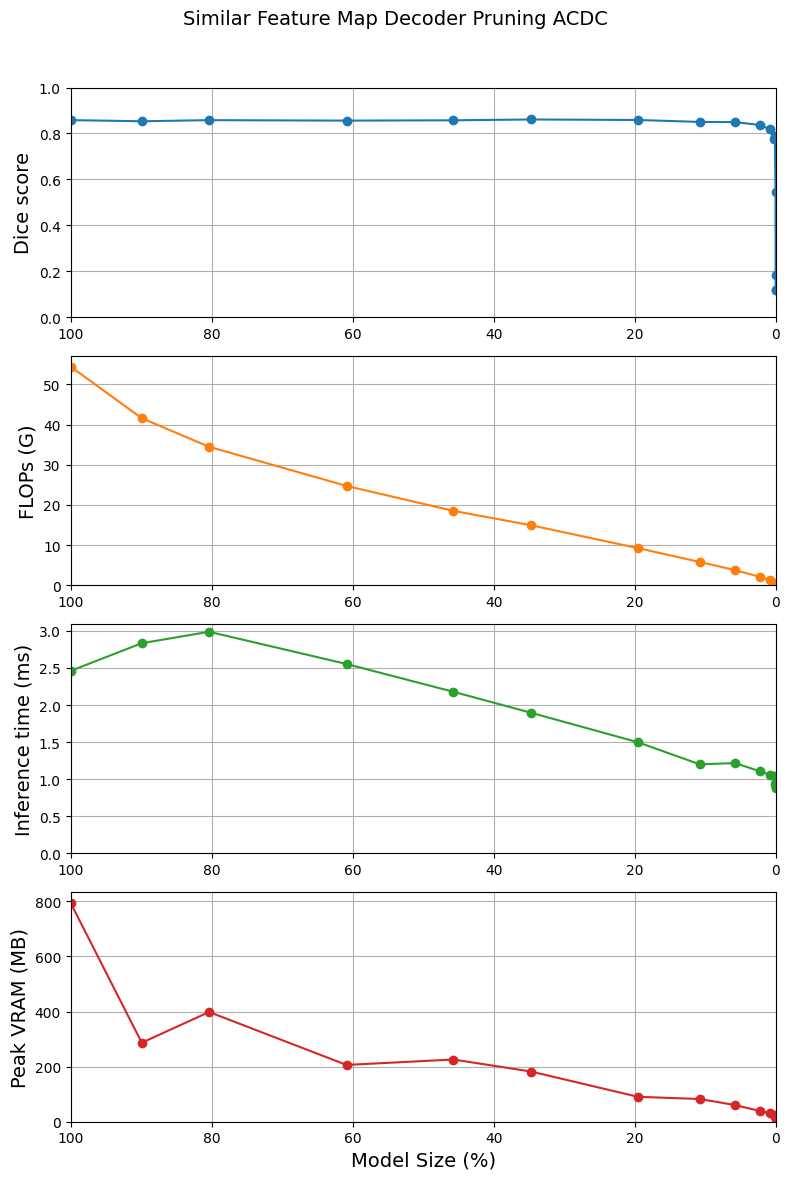

In [6]:
def plot_pruning_summary(df, x_col, y_col):

    plt.figure(figsize=(8, 12))
    fs = 14

    # 1. Dice
    plt.subplot(4, 1, 1)
    plt.plot(df[x_col], df[y_col[0]], marker="o", color="tab:blue")
    plt.ylabel("Dice score", fontsize=fs)
    plt.ylim(0, 1)
    plt.xlim(max(df[x_col]), 0) 
    plt.grid(True)

    # 2. FLOPs
    plt.subplot(4, 1, 2)
    plt.plot(df[x_col], df[y_col[1]], marker="o", color="tab:orange")
    plt.ylabel("FLOPs (G)", fontsize=fs)
    plt.xlim(max(df[x_col]), 0) 
    plt.ylim(bottom=0)
    plt.grid(True)

    # 3. Inference time
    plt.subplot(4, 1, 3)
    plt.plot(df[x_col], df[y_col[2]], marker="o", color="tab:green")
    plt.ylabel("Inference time (ms)", fontsize=fs)
    plt.xlim(max(df[x_col]), 0) 
    plt.ylim(bottom=0)
    plt.grid(True)

    # 4. VRAM
    plt.subplot(4, 1, 4)
    plt.plot(df[x_col], df[y_col[3]], marker="o", color="tab:red")
    plt.xlabel("Model Size (%)", fontsize=fs)
    plt.ylabel("Peak VRAM (MB)", fontsize=fs)
    plt.xlim(max(df[x_col]), 0) 
    plt.ylim(bottom=0)
    plt.grid(True)

    plt.suptitle(f'Similar Feature Map Decoder Pruning ACDC', fontsize=fs)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



plot_pruning_summary(df_uniform, "model_size_pct", ["mean_dice_fg", "flops_g", "inference_ms", "vram_peak_mb"])


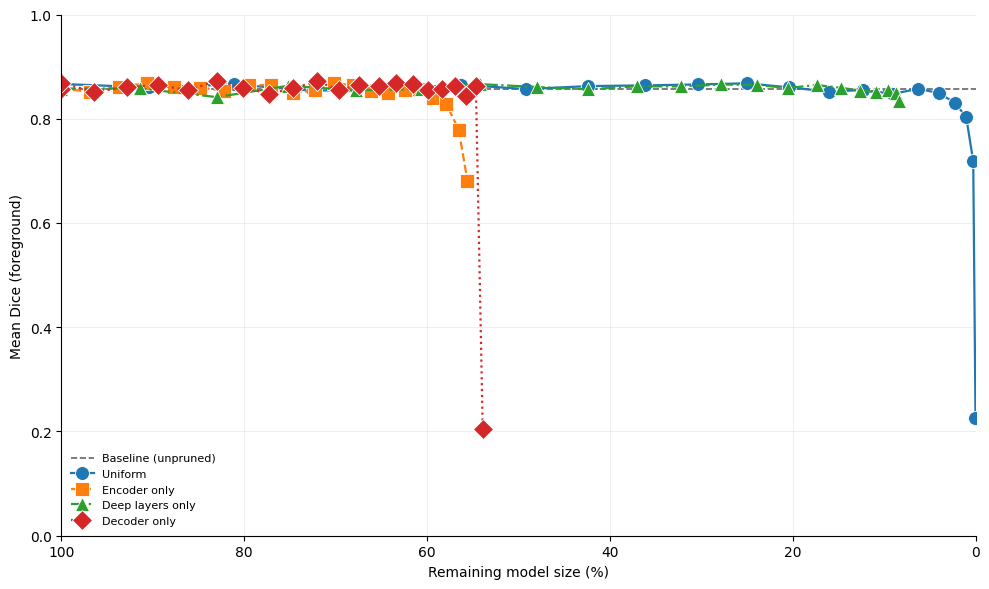

In [4]:
import matplotlib.pyplot as plt

def plot_pruning_locations(
    df_uniform,
    df_encoder,
    df_deep,
    df_decoder,
    *,
    title=None,
    save_path=None,
):
    fig, ax = plt.subplots(figsize=(10, 6))

    # --------------------------------------------------
    # Baseline (first datapoint, identical across dfs)
    # --------------------------------------------------
    baseline_dice = df_uniform.iloc[0]["mean_dice_fg"]

    ax.axhline(
        baseline_dice,
        linestyle="--",
        linewidth=1.2,
        color="black",
        alpha=0.6,
        label="Baseline (unpruned)",
    )

    lines = [
        (df_uniform, "Uniform", "o", "-", "#1f77b4"),
        (df_encoder, "Encoder only", "s", "--", "#ff7f0e"),
        (df_deep, "Deep layers only", "^", "-.", "#2ca02c"),
        (df_decoder, "Decoder only", "D", ":", "#d62728"),
    ]

    for df, label, marker, linestyle, color in lines:
        ax.plot(
            df["model_size_pct"],
            df["mean_dice_fg"],
            label=label,
            marker=marker,
            linestyle=linestyle,
            linewidth=1.6,
            markersize=10,
            markeredgecolor="white",
            markeredgewidth=0.6,
            color=color,
        )

    # Labels
    ax.set_xlabel("Remaining model size (%)")
    ax.set_ylabel("Mean Dice (foreground)")

    # Optional title (thesis-friendly)
    if title is not None:
        ax.set_title(title, fontsize=10, pad=6)

    # Axis limits
    ax.set_xlim(
        max(df_uniform["model_size_pct"]),
        0,
    )
    ax.set_ylim(0.0, 1.0)

    # Subtle grid
    ax.grid(True, which="major", linewidth=0.5, alpha=0.3)

    # Clean spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Legend
    ax.legend(frameon=False, fontsize=8, loc="lower left")

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()

    plt.close(fig)



plot_pruning_locations(
    df_uniform,
    df_encoder,
    df_deep,
    df_decoder,
    # save_path="figures/results/fig_4_2_acdc_pruned_only.pdf",
)
